# Exploring the Sentinel 2 STAC catalog tools

In [1]:
import rasterio
import shutil
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
from geospatial_tools import DATA_DIR, TESTS_DIR
from geospatial_tools.stac import StacSearch, PLANETARY_COMPUTER
from geospatial_tools.utils import create_date_range_for_specific_period

In [2]:
TEST_TMP_DIR = TESTS_DIR / "tmp_stac_api_tools"
TEST_TMP_DIR.mkdir(exist_ok=True)

In [3]:
S2_USA_GRID_FILE = DATA_DIR / "s2_grid_usa_polygon_5070.gpkg"
s2_grid = gpd.read_file(S2_USA_GRID_FILE)

## Search Parameters

Now we search for our product.

In this demonstration, we want relatively recent products, and only from June or July

We are looking for Sentinel 2 products that are already pre-processed and that have 
minimal cloud cover.

We are also limiting our search to the `10SDJ` tile.



In [4]:
# Date ranges
start_year = 2024
end_year = 2024
start_month = 6
end_month = 7
date_ranges = create_date_range_for_specific_period(start_year=start_year,
                                                    end_year=end_year,
                                                    start_month_range=start_month,
                                                    end_month_range=end_month)

# Search arguments
collection = "sentinel-2-l2a"
tile_ids = ["10SDJ"]
max_cloud_cover = 1
max_no_data_value = 5
query = {"eo:cloud_cover": {"lt": max_cloud_cover}, "s2:mgrs_tile": {"in": tile_ids}}
sortby = [{"field": "properties.eo:cloud_cover", "direction": "asc"}]

# Searching for results
search_client = StacSearch(PLANETARY_COMPUTER)
search_client.search_for_date_ranges(date_ranges=date_ranges,
                                     collections=collection,
                                     query=query,
                                     sortby=sortby, limit=100)

# Selecting optimal result
search_client.sort_results_by_cloud_coverage()
search_client.filter_no_data(property_name="s2:nodata_pixel_percentage", max_no_data_value=max_no_data_value)

filtered_items = search_client.filtered_results
optimal_result = filtered_items[0]

[2024-09-19 17:42:53] INFO       [MainThread][geospatial_tools.stac] Running STAC API search for the following date ranges : 
	[['2024-06-01T00:00:00Z/2024-07-31T23:59:59Z'] 
	Query : [{'eo:cloud_cover': {'lt': 1}, 's2:mgrs_tile': {'in': ['10SDJ']}}]


In [5]:
print("\nSorted results")
for item in filtered_items:
    print(f"Item: {item.id}, {item.datetime}, "
          f"Cloud cover: {item.properties['eo:cloud_cover']}, "
          f"Nodata: {item.properties['s2:nodata_pixel_percentage']}")

print(f"\nOptimal result: {optimal_result.id}, {optimal_result.datetime}, "
      f"Cloud cover: {optimal_result.properties['eo:cloud_cover']}, "
      f"Nodata: {optimal_result.properties['s2:nodata_pixel_percentage']}")


Sorted results
Item: S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346, 2024-07-05 18:59:21.024000+00:00, Cloud cover: 0.006778, Nodata: 1.7e-05
Item: S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346, 2024-07-05 18:59:21.024000+00:00, Cloud cover: 0.006778, Nodata: 1.7e-05
Item: S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346, 2024-07-05 18:59:21.024000+00:00, Cloud cover: 0.006778, Nodata: 1.7e-05
Item: S2A_MSIL2A_20240725T185921_R013_T10SDJ_20240726T025650, 2024-07-25 18:59:21.024000+00:00, Cloud cover: 0.0543, Nodata: 0.0
Item: S2A_MSIL2A_20240725T185921_R013_T10SDJ_20240726T025650, 2024-07-25 18:59:21.024000+00:00, Cloud cover: 0.0543, Nodata: 0.0
Item: S2A_MSIL2A_20240725T185921_R013_T10SDJ_20240726T025650, 2024-07-25 18:59:21.024000+00:00, Cloud cover: 0.0543, Nodata: 0.0

Optimal result: S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346, 2024-07-05 18:59:21.024000+00:00, Cloud cover: 0.006778, Nodata: 1.7e-05


In [6]:
# NBVAL_IGNORE_OUTPUT
bands = ["visual"]
file_base_path = Path(f"{TEST_TMP_DIR}/sentinel-2/")
best_result = search_client.download_best_cloud_cover_result(bands=bands, base_directory=file_base_path)

[2024-09-19 17:42:54] INFO       [MainThread][geospatial_tools.stac] Downloading [S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346] ...
[2024-09-19 17:42:54] INFO       [MainThread][geospatial_tools.stac] Downloading visual from https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/S/DJ/2024/07/05/S2A_MSIL2A_20240705T185921_N0510_R013_T10SDJ_20240706T050346.SAFE/GRANULE/L2A_T10SDJ_A047200_20240705T190418/IMG_DATA/R10m/T10SDJ_20240705T185921_TCI_10m.tif?st=2024-09-18T21%3A42%3A54Z&se=2024-09-19T22%3A27%3A54Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-09-19T18%3A42%3A51Z&ske=2024-09-26T18%3A42%3A51Z&sks=b&skv=2024-05-04&sig=ZG%2Bz4R7yq0YsPT5iIoQVSqatpSQTf%2B72NTaX0TG8qV0%3D
[2024-09-19 17:43:38] INFO       [MainThread][geospatial_tools.utils] Downloaded /home/francispelletier/projects/geospatial_tools/tests/tmp_stac_api_tools/sentinel-2/S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346_visual.t

In [7]:
best_result.asset_id

'S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346'

In [8]:
merged = best_result.merge_asset(base_directory=file_base_path, delete_sub_items=True)
reprojected = best_result.reproject_merged_asset(target_projection=5070, 
                                                 base_directory=file_base_path,
                                                 delete_merged_asset=True)

[2024-09-19 17:43:38] INFO       [MainThread][geospatial_tools.stac] Calculated a total of [3] bands
[2024-09-19 17:43:38] INFO       [MainThread][geospatial_tools.stac] 3
[2024-09-19 17:43:38] INFO       [MainThread][geospatial_tools.stac] Creating merged asset metadata
[2024-09-19 17:43:38] INFO       [MainThread][geospatial_tools.stac] Merging asset [S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346] ...
[2024-09-19 17:43:38] INFO       [MainThread][geospatial_tools.stac] Writing band image: S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346
[2024-09-19 17:43:38] INFO       [MainThread][geospatial_tools.stac] writing asset sub item band 1
[2024-09-19 17:43:38] INFO       [MainThread][geospatial_tools.stac] writing merged index band 1
[2024-09-19 17:43:40] INFO       [MainThread][geospatial_tools.stac] writing asset sub item band 2
[2024-09-19 17:43:40] INFO       [MainThread][geospatial_tools.stac] writing merged index band 2
[2024-09-19 17:43:40] INFO       [MainThread][ge

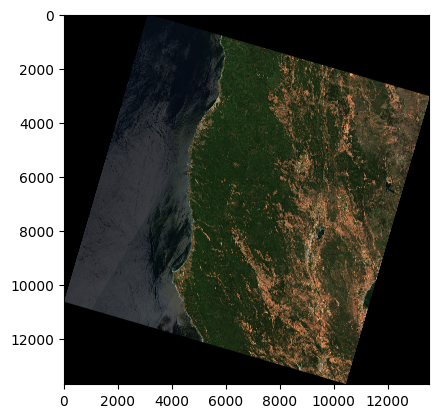

In [9]:
image_path = str(reprojected)

with rasterio.open(image_path) as src:
    bands = src.read((1,2,3))
    plt.imshow(bands.transpose(1, 2, 0)) 
    plt.show()

In [10]:
shutil.rmtree(TEST_TMP_DIR)